# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheetname=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

C:\Users\parky\Anaconda3\lib\site-packages\pandas\util\_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [3]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheetname=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

C:\Users\parky\Anaconda3\lib\site-packages\pandas\util\_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [4]:
# Join two tables
df = df_transactions.merge(df_offers, how = 'left')
df.shape

(324, 9)

In [5]:
# First few rows
df.head()

,customer_name,offer_id,n,campaign,varietal,min_qty,discount,origin,past_peak
0,Smith,2,1,January,Pinot Noir,72,17,France,False
1,Smith,24,1,September,Pinot Noir,6,34,Italy,False
2,Johnson,17,1,July,Pinot Noir,12,47,Germany,False
3,Johnson,24,1,September,Pinot Noir,6,34,Italy,False
4,Johnson,26,1,October,Pinot Noir,144,83,Australia,False


In [6]:
# Count the number of coustomers and offers
print('Number of customers: {}'.format(len(df.customer_name.value_counts())))
print('Number of offers: {}'.format(len(df.offer_id.value_counts())))

Number of customers: 100
Number of offers: 32


In [7]:
# Check missingness
for col in df.columns:
    print ('{:>13}: {}'.format(col, np.sum(df[col].isnull())))

customer_name: 0
     offer_id: 0
            n: 0
     campaign: 0
     varietal: 0
      min_qty: 0
     discount: 0
       origin: 0
    past_peak: 0


In [8]:
# Pivot table for customers by offer ids
pivot = pd.pivot_table(df, values = 'n', index = ['customer_name'], columns = ['offer_id'], 
                       fill_value = 0, aggfunc = np.sum)
pivot.shape

(100, 32)

In [9]:
# First few rows
pivot.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
Allen,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
Anderson,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
Bailey,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Baker,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

### What values of SS do you believe represent better clusterings? Why? 
I believe that the smaller ss (the sum of quared distances from centroids), the smaller variability within a cluster and the better clustring, as long as the number of clusters is not to big.

In [10]:
# Matix of binary values
X_cols = np.matrix(pivot)
X_cols

matrix([[0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 1]], dtype=int64)

In [11]:
# Function for getting sum of squares
def get_ss(data_matrix, labels, centers):
    ss = 0
    for i in range(len(data_matrix)):
        center = centers[labels[i]]
        errors = (data_matrix[i] - center).tolist()[0]
        for e in errors:
            ss += e**2
        
    return ss

In [12]:
# K-means clustering
from sklearn.cluster import KMeans
k_tests = range(2, 11)
n_tests = len(k_tests)
sss = [] # List of ss

for k in k_tests:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(X_cols)
    labels = kmeans.predict(X_cols) 
    centers = kmeans.cluster_centers_
    sss.append(get_ss(X_cols, labels, centers))


ss_tab = pd.DataFrame({'n_clusters': k_tests, 'sum_of_squares': sss})
print(ss_tab)

   n_clusters  sum_of_squares
0           2      251.460317
1           3      227.793236
2           4      214.221400
3           5      206.831914
4           6      194.322331
5           7      188.603185
6           8      180.341489
7           9      172.635784
8          10      167.739927


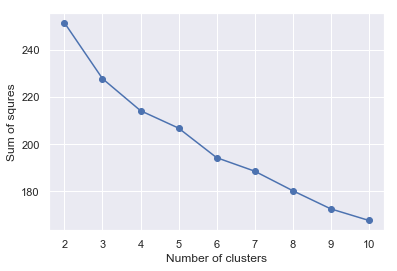

In [13]:
# Plot of the sum of squares vs. the number of clusters
sns.set()
plt.plot(ss_tab['n_clusters'], ss_tab['sum_of_squares'], '-o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squres')
plt.xticks(ss_tab.n_clusters)
plt.show()

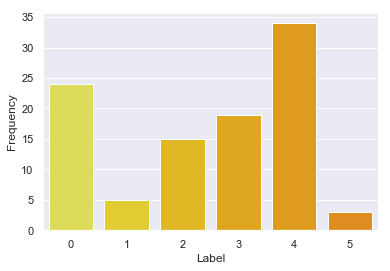

In [14]:
# Choose k = 6
from collections import Counter
kmeans_6 = KMeans(n_clusters = 6)
labels = kmeans_6.fit_predict(X_cols)

# Count frequencies
counts = Counter(labels)
labels = []
frequencies = []

for i in range(len(counts)):
    labels.append(i)
    frequencies.append(counts[i])

# Plot the frequencies
sns.set()
sns.barplot(x = labels, y = frequencies, palette = 'Wistia')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

During the exercise of Elbow method to choos the number of clusters, it is quite hard to meke a decision about the location of the elnow as the plot is fairly smooth. Also when the k-means clustering is repeating, the outputs are quite different.  So after a number of tries, we decided to go with k = 6.

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

In [15]:
# Silhouette score
from sklearn.metrics import silhouette_score
k_tests = range(2, 11)
n_tests = len(k_tests)
sss = [] # List of silhouette scores

for k in k_tests:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(X_cols)
    labels = kmeans.predict(X_cols) 
    sss.append(silhouette_score(X_cols, labels))


ss_tab = pd.DataFrame({'n_clusters': k_tests, 'silhouette_score': sss})
print(ss_tab)

   n_clusters  silhouette_score
0           2          0.091749
1           3          0.121016
2           4          0.114705
3           5          0.137444
4           6          0.117431
5           7          0.100458
6           8          0.115405
7           9          0.103094
8          10          0.117705


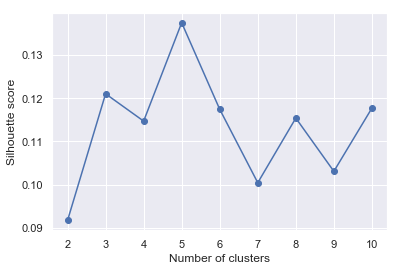

In [16]:
# Plot of the silhouette scores vs. the number of clusters
sns.set()
plt.plot(ss_tab['n_clusters'], ss_tab['silhouette_score'], '-o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.xticks(ss_tab.n_clusters)
plt.show()

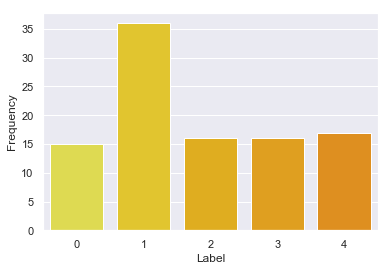

In [22]:
# Choose k = 5
from collections import Counter
kmeans_5 = KMeans(n_clusters = 5)
labels = kmeans_5.fit_predict(X_cols)

# Count frequencies
counts = Counter(labels)
labels = []
frequencies = []

for i in range(len(counts)):
    labels.append(i)
    frequencies.append(counts[i])

# Plot the frequencies
sns.set()
sns.barplot(x = labels, y = frequencies, palette = 'Wistia')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

From the Silhouettte score test for the k-mean clustering we found that the wine campaign data show the best score at five clusters.  This result is dfferent from the earlier one of the choice of six clusters with Elbow method: We revisit the plot of Sum of Squares (SS) for different clusters, there is a quite significant drop of SS from five clusters to six clusters.  

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [23]:
# Loads modules
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline

In [24]:
# Apply PCA and KMeans
customer_name = pivot.index
pca = PCA(n_components = 2)
kmeans_6 = KMeans(n_clusters = 6)
pipeline = make_pipeline(pca, kmeans_6)
pipeline.fit_predict(X_cols)
transformed = pd.DataFrame(X_cols.dot(pca.components_.transpose()))
xs = transformed[0]
ys = transformed[1]
labels_6 = kmeans_6.labels_

kmeans_5 = KMeans(n_clusters = 5)
pipeline = make_pipeline(pca, kmeans_5)
pipeline.fit_predict(X_cols)
transformed = pd.DataFrame(X_cols.dot(pca.components_.transpose()))
labels_5 = kmeans_5.labels_
kmeans_tab = pd.DataFrame({'Customer_name': customer_name,
                           'Component1': xs,
                           'Component2': ys,
                           'Label_k6': labels_6,
                           'Label_k5': labels_5})
kmeans_tab.head(10)

,Component1,Component2,Customer_name,Label_k5,Label_k6
0,1.058618,-0.083425,Adams,4,0
1,-0.236501,-0.146925,Allen,3,1
2,-0.340994,0.846752,Anderson,2,2
3,0.750515,-0.214182,Bailey,0,3
4,0.139221,-0.663335,Baker,1,5
5,-0.434244,-0.917143,Barnes,1,4
6,-0.540903,1.314860,Bell,2,2
7,0.712770,-0.101332,Bennett,0,3
8,-0.067905,-0.769138,Brooks,1,5
9,1.130866,-0.199128,Brown,4,0


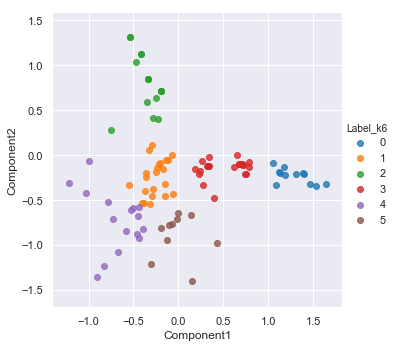

In [25]:
# Plot of six clusters
sns.lmplot(x = 'Component1', y = 'Component2', hue = 'Label_k6', palette = 'tab10', 
                data = kmeans_tab, fit_reg = False)
plt.axis('equal')
plt.show()

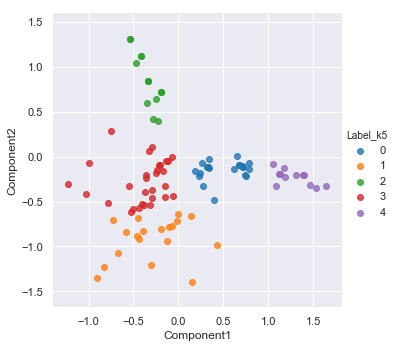

In [26]:
# Plot of five clusters
sns.lmplot(x = 'Component1', y = 'Component2', hue = 'Label_k5', palette = 'tab10', 
                data = kmeans_tab, fit_reg = False)
plt.axis('equal')
plt.show()

From the visual assessment for comparint fwo clustring labels - one for six clusters and another for five clusters - the five clusters seem to have better fit as we can see wider gaps between groups than the other one.  It implieas that the silhouette method woks better for the given data.

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

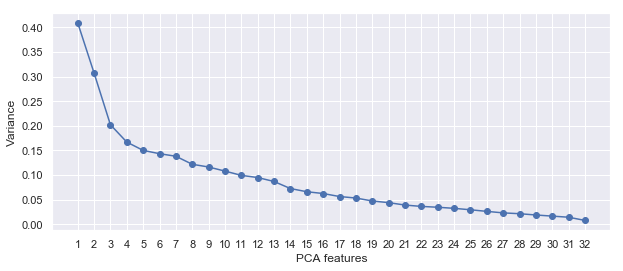

In [21]:
# Initialize a new PCA model with a default number of components.
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_cols)
features = range(1, pca.n_components_+1)
f,ax = plt.subplots(figsize = (10, 4))
plt.plot(features, pca.explained_variance_, '-o')
plt.xticks(features)
plt.xlabel('PCA features')
plt.ylabel('Variance')
plt.show()

In [27]:
# Append label to the original data
kmeans_df = kmeans_tab[['Customer_name', 'Component1', 'Component2', 'Label_k5']]
kmeans_df.columns = ['customer_name', 'component1', 'component2', 'label']
df_new = df.merge(kmeans_df, how = 'left')
df_new.head()

,customer_name,offer_id,n,campaign,varietal,min_qty,discount,origin,past_peak,component1,component2,label
0,Smith,2,1,January,Pinot Noir,72,17,France,False,-0.249189,0.638126,2
1,Smith,24,1,September,Pinot Noir,6,34,Italy,False,-0.249189,0.638126,2
2,Johnson,17,1,July,Pinot Noir,12,47,Germany,False,-0.410688,1.121845,2
3,Johnson,24,1,September,Pinot Noir,6,34,Italy,False,-0.410688,1.121845,2
4,Johnson,26,1,October,Pinot Noir,144,83,Australia,False,-0.410688,1.121845,2


In [28]:
# Check correlation between minimum quantity and label
np.corrcoef(df_new.min_qty, df_new.label)

array([[1.        , 0.00791142],
       [0.00791142, 1.        ]])

In [29]:
# Check correlation between discount and label
np.corrcoef(df_new.discount, df_new.label)

array([[1.        , 0.01352883],
       [0.01352883, 1.        ]])

From these two correlation matrices, we see neither correlation between the minimum quantity and label nor the one between the discount and label.

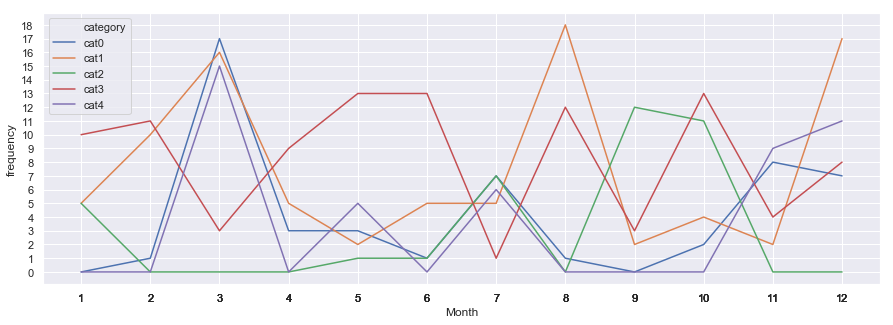

In [30]:
# Check any pattern campaign by label
month_tab = pd.pivot_table(df_new, values = 'n', index = ['campaign'], columns = ['label'], 
                       fill_value = 0, aggfunc = np.sum)
month_tab['month'] = month_tab.index
month_dict = {'April':4, 'August':8, 'December':12, 'February':2, 
              'January':1, 'July':7, 'June':6, 'March':3,
              'May':5, 'November':11, 'October':10, 'September':9}
month_tab.index = month_dict.values()
month_tab.sort_index(inplace = True)
month_tab.columns = ['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'month']
month_tab['label'] = month_tab.index
month_tab = month_tab.melt(id_vars = ['month', 'label'], var_name = 'category', 
                           value_name = 'frequency')

# Plot
plt.figure(figsize = (15, 5))
sns.set(style = 'darkgrid')
sns.lineplot(x = 'label', y = 'frequency', hue = 'category', data = month_tab)
plt.xticks(month_tab.label)
plt.yticks(range(19))
plt.xlabel('Month')
plt.show()

It is hard to find any common or contrast patterns of monthly change in frequency among the label groups.

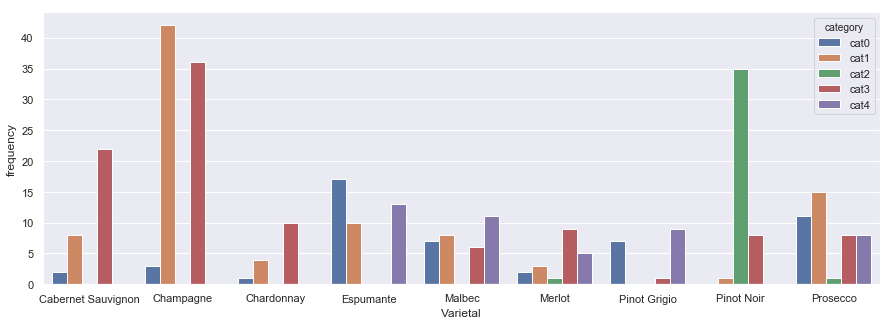

In [31]:
# Check any pattern of varietal by label
varietal_tab = pd.pivot_table(df_new, values = 'n', index = ['varietal'], columns = ['label'], 
                       fill_value = 0, aggfunc = np.sum)
varietal_tab['varietal'] = varietal_tab.index
varietal_tab.columns = ['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'varietal']
varietal_tab
varietal_tab = varietal_tab.melt(id_vars = ['varietal'], var_name = 'category', 
                           value_name = 'frequency')

# Plot
plt.figure(figsize = (15, 5))
sns.set(style = 'darkgrid')
sns.barplot(x = 'varietal', y = 'frequency', hue = 'category', data = varietal_tab, dodge = True)
plt.xlabel('Varietal')
plt.show()

There are interesting characteristics in the categorial bar plot of frequency versus varietal - category 2 group appears to be favoured on pinot noir and category 1 and 3 groups are favoured on champagne most. The other three groups does not show any apesific favoured varietal.

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [32]:
# Affinity propagation
from sklearn.cluster import AffinityPropagation

customer_name = pivot.index
pca = PCA(n_components = 2)
ap = AffinityPropagation()
pipeline = make_pipeline(pca, ap)
pipeline.fit_predict(X_cols)
transformed = pd.DataFrame(X_cols.dot(pca.components_.transpose()))
xs = transformed[0]
ys = transformed[1]
labels = ap.labels_
ap_tab = pd.DataFrame({'Customer_name': customer_name,
                       'Component1': xs,
                       'Component2': ys,
                       'Label': labels})

print('Number of clusters from Affinity Propagation: {}'.format(ap.cluster_centers_indices_.shape[0]))

Number of clusters from Affinity Propagation: 10


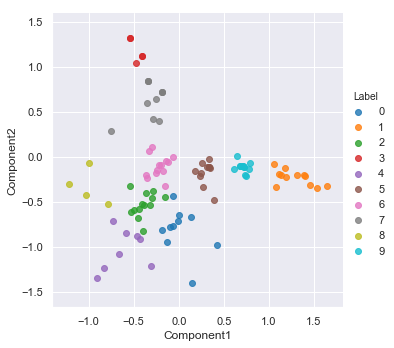

In [33]:
# Plot
sns.lmplot(x = 'Component1', y = 'Component2', hue = 'Label', palette = 'tab10', 
                data = ap_tab, fit_reg = False)
plt.axis('equal')
plt.show()

In [24]:
print('Silhouette score of affinity propagation: {}'.format(silhouette_score(X_cols, labels)))

Silhouette score of affinity propagation: 0.008805486048072199


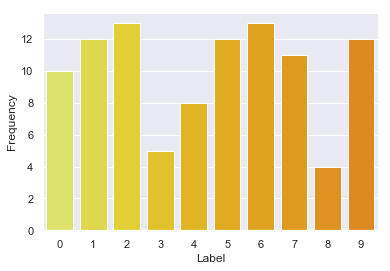

In [34]:
# Barplot of labels
from collections import Counter

# Count frequencies
counts = Counter(labels)
labels = []
frequencies = []

for i in range(len(counts)):
    labels.append(i)
    frequencies.append(counts[i])

# Plot the frequencies
sns.set()
sns.barplot(x = labels, y = frequencies, palette = 'Wistia')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

Affinity propagation method does not need to set the nymber of clusters, instead the algorithm itself chooses the numbers - here it is 10.  The 2D plot shows that some clusters almost attach each other. Silhouette score for the method is 0.0088, quite small. To compare this with other algorithms, we set the number of clusters as 10 for the other algorithms as well.

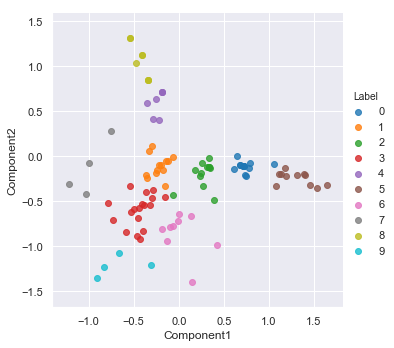

In [35]:
# Spectral clustering
# Apply PCA and SpectralClustering with k=10
from sklearn.cluster import SpectralClustering

customer_name = pivot.index
pca = PCA(n_components = 2)
spec = SpectralClustering(n_clusters = 10)
pipeline = make_pipeline(pca, spec)
pipeline.fit_predict(X_cols)
transformed = pd.DataFrame(X_cols.dot(pca.components_.transpose()))
xs = transformed[0]
ys = transformed[1]
labels = spec.labels_
spec_tab = pd.DataFrame({'Customer_name': customer_name,
                         'Component1': xs,
                         'Component2': ys,
                         'Label': labels})

# Plot
sns.lmplot(x = 'Component1', y = 'Component2', hue = 'Label', palette = 'tab10', 
           data = spec_tab, fit_reg = False)
plt.axis('equal')
plt.show()

In [36]:
print('Silhouette score of spectral clustering: {}'.format(silhouette_score(X_cols, labels)))

Silhouette score of spectral clustering: 0.02323948149606547


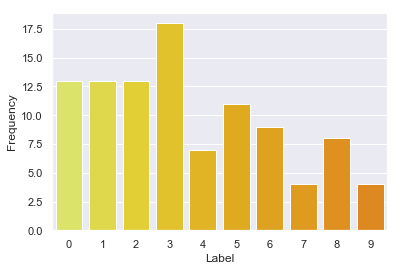

In [37]:
from collections import Counter

# Count frequencies
counts = Counter(labels)
labels = []
frequencies = []

for i in range(len(counts)):
    labels.append(i)
    frequencies.append(counts[i])

# Plot the frequencies
sns.set()
sns.barplot(x = labels, y = frequencies, palette = 'Wistia')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

Spectral clustring with the same number of clusters as the earlier one extract a better clustering result as the plot shows a bit greater gaps among groups, and the silhouette score is also increased -it scores 0.0232.

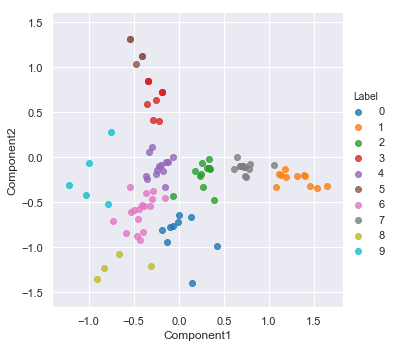

In [38]:
# Agglomerative Clustering
# Apply PCA and AgglomerativeClustering with k=10

from sklearn.cluster import AgglomerativeClustering

customer_name = pivot.index
pca = PCA(n_components = 2)
aggl = SpectralClustering(n_clusters = 10)
pipeline = make_pipeline(pca, aggl)
pipeline.fit_predict(X_cols)
transformed = pd.DataFrame(X_cols.dot(pca.components_.transpose()))
xs = transformed[0]
ys = transformed[1]
labels = aggl.labels_
aggl_tab = pd.DataFrame({'Customer_name': customer_name,
                       'Component1': xs,
                       'Component2': ys,
                       'Label': labels})

# Plot
sns.lmplot(x = 'Component1', y = 'Component2', hue = 'Label', palette = 'tab10', 
                data = aggl_tab, fit_reg = False)
plt.axis('equal')
plt.show()

In [39]:
print('Silhouette score of agglomerative clustering: {}'.format(silhouette_score(X_cols, labels)))

Silhouette score of agglomerative clustering: 0.017267703463766756


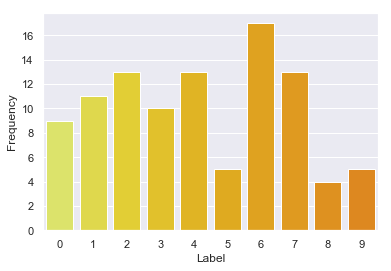

In [40]:
from collections import Counter

# Count frequencies
counts = Counter(labels)
labels = []
frequencies = []

for i in range(len(counts)):
    labels.append(i)
    frequencies.append(counts[i])

# Plot the frequencies
sns.set()
sns.barplot(x = labels, y = frequencies, palette = 'Wistia')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

Agglomerative clustering has a better fit than the affinity propagation, but a worse fit than thespectral clustring according to the silhouette score - the score of this is 0.0173. 

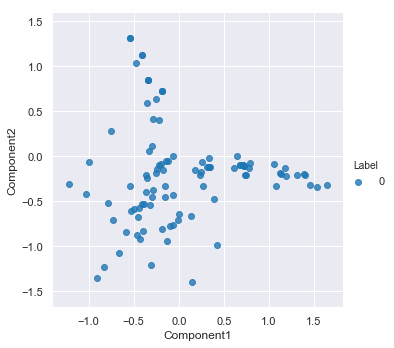

In [159]:
# DBSCAN 
# Apply PCA and DBSCAN
from sklearn.cluster import DBSCAN

customer_name = pivot.index
pca = PCA(n_components = 2)
dbscan = DBSCAN()
pipeline = make_pipeline(pca, dbscan)
pipeline.fit_predict(X_cols)
transformed = pd.DataFrame(X_cols.dot(pca.components_.transpose()))
xs = transformed[0]
ys = transformed[1]
labels = dbscan.labels_
dbscan_tab = pd.DataFrame({'Customer_name': customer_name,
                           'Component1': xs,
                           'Component2': ys,
                           'Label': labels})

# Plot
sns.lmplot(x = 'Component1', y = 'Component2', hue = 'Label', palette = 'tab10', 
                data = dbscan_tab, fit_reg = False)
plt.axis('equal')
plt.show()

In [38]:
# Print labels
dbscan.fit_predict(X_cols)

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      dtype=int64)

DBSCAN with default parameters does not seem to work for our data: the plot of its output shows the only color for all points - all of the prediction vlaues have -1, which implies that they are regarded as noises according to the Python documentation (http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html).